Data analysis for firm dynamics project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from shapely.geometry import Point
from scipy.optimize import minimize, minimize_scalar

Creating the dataframes

In [104]:
df = pd.read_csv('ACRA_w_SO.csv')

# Drop rows where Coordinate_X or Coordinate_Y is -1
df = df[(df['Coordinate_X'] != -1) & (df['Coordinate_Y'] != -1)]

# Initialise new dataframe for data we want to analyse
df_analysis = pd.DataFrame()
df_analysis['uen'] = df['uen']
df_analysis['Sector'] = df['Sector']
df_analysis['status'] = df['status']

# Convert the 5 struck off dates to datetime
date_cols = [f'Struck Off Date {i}' for i in range(1, 6)]
df[date_cols] = df[date_cols].apply(pd.to_datetime)

# Calculate the average date for each firm
df_analysis['Exit Date'] = df[date_cols].mean(axis=1)
df_analysis['Entry Date'] = df['registration_incorporation_date']

In [105]:
df.head()

,Unnamed: 0,uen,entity_status_description,registration_incorporation_date,primary_ssic_code,no_of_officers,postal_code,Sector,Coordinate_X,Coordinate_Y,Struckoff_date,status,Struck Off Date 1,Struck Off Date 2,Struck Off Date 3,Struck Off Date 4,Struck Off Date 5
0,0,53376145W,Ceased Registration,2018-01-13T10:32:56,81211,1,786092,N,26965.946069,43165.257359,NaN,0,2019-07-13,2019-07-13,2022-07-13,2021-07-13,2018-07-13
1,1,53290857X,Live,2015-02-26T12:02:44,95220,1,571275,S,29135.238841,37635.655227,NaN,1,NaT,NaT,NaT,NaT,NaT
3,3,200412424K,Live Company,2004-09-28T17:56:29,47713,5,658077,G,19640.197381,35557.098364,NaN,1,NaT,NaT,NaT,NaT,NaT
4,4,53396472E,Ceased Registration,2019-04-11T21:20:43,49215,1,082001,H,29026.583059,28597.376389,NaN,0,2019-10-11,2019-10-11,2021-10-11,2022-10-11,2019-10-11
5,5,48376900B,na,1993-04-12T00:00:00,96021,3,557801,S,31540.107755,38516.964477,NaN,0,1998-10-12,1994-10-12,2003-10-12,1998-10-12,2003-10-12


Adding age column

In [106]:
# Convert Entry Date to datetime
df_analysis['Entry Date'] = pd.to_datetime(df_analysis['Entry Date'])

# Calculate age in years
current_time = df_analysis['Exit Date'].max()
df_analysis['Age'] = (max(df_analysis['Entry Date']) - df_analysis['Entry Date']).dt.days / 365.25

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Age
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,4.906229
1,53290857X,S,1,NaT,2015-02-26 12:02:44,7.786448
3,200412424K,G,1,NaT,2004-09-28 17:56:29,18.198494
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,3.665982
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,29.661875


In [ ]:
# Testing for number in each sector
sector_counts = df_analysis['Sector'].value_counts()
print(sector_counts)

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']

Sector
G    519007
M    212475
F    122726
J    114892
K    114415
C    106661
H     94296
S     84627
N     84187
I     79463
P     49791
L     30740
Q     24803
R     17800
A      3234
E      2453
B      2211
D      1366
T      1287
O       363
U        47
Name: count, dtype: int64


Splitting SG into 12 regions

In [108]:
# Should I bound by furthest firms? Or based on the area of Singapore instead?
x_min, x_max = df['Coordinate_X'].min()-0.1, df['Coordinate_X'].max()+0.1
y_min, y_max = df['Coordinate_Y'].min()-0.1, df['Coordinate_Y'].max()+0.1

print(f"Coordinate_X: min={x_min}, max={x_max}")
print(f"Coordinate_Y: min={y_min}, max={y_max}")

df_analysis['Coordinate_X'] = df['Coordinate_X']
df_analysis['Coordinate_Y'] = df['Coordinate_Y']

# Setting boundaries for the 12 regions
x_array = np.linspace(x_min, x_max, 5)
y_array = np.linspace(y_min, y_max, 4)

print(x_array)
print(y_array)

# Define region labels for x and y
x_labels = ['A', 'B', 'C', 'D']
y_labels = ['1', '2', '3']

# Assign x region (A, B, C, D) based on Coordinate_X
x_region = pd.cut(df['Coordinate_X'], bins=x_array, labels=x_labels, include_lowest=True, right=False)

# Assign y region (1, 2, 3) based on Coordinate_Y
y_region = pd.cut(df['Coordinate_Y'], bins=y_array, labels=y_labels, include_lowest=True, right=False)

# Combine to form region code (e.g., A1, B2, etc.)
df_analysis['Region'] = x_region.astype(str) + y_region.astype(str)

df_analysis.head()

Coordinate_X: min=3371.661129201186, max=53137.16000076222
Coordinate_Y: min=23536.28834579989, max=50187.241339099855
[ 3371.6611292  15813.03584709 28254.41056498 40695.78528287
 53137.16000076]
[23536.2883458  32419.93934357 41303.59034133 50187.2413391 ]


,uen,Sector,status,Exit Date,Entry Date,Age,Coordinate_X,Coordinate_Y,Region
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,4.906229,26965.946069,43165.257359,B3
1,53290857X,S,1,NaT,2015-02-26 12:02:44,7.786448,29135.238841,37635.655227,C2
3,200412424K,G,1,NaT,2004-09-28 17:56:29,18.198494,19640.197381,35557.098364,B2
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,3.665982,29026.583059,28597.376389,C1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,29.661875,31540.107755,38516.964477,C2


Plotting age distribution, by region

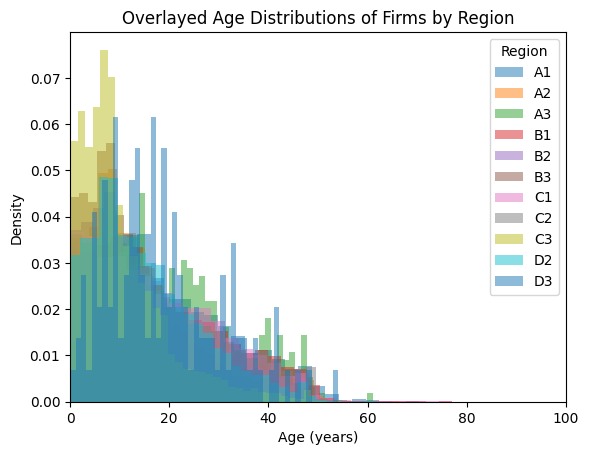

In [109]:
fig, ax = plt.subplots()

for region, group in df_analysis.groupby('Region'):
    plt.hist(
        group['Age'].dropna(),
        bins=50,
        alpha=0.5,
        label=region,
        density=True
    )

plt.title('Overlayed Age Distributions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.show()

Trying geopandas instead

In [110]:
# Read the KML file
regions = gpd.read_file('region_boundary.geojson')
regions = regions.to_crs("EPSG:3414") # Convert to Singapore CRS

print(regions['Description'][0]) # WR
print(regions['Description'][1]) # NR
print(regions['Description'][2]) # NER
print(regions['Description'][3]) # ER
print(regions['Description'][4]) # CR

# Map the region names to the corresponding codes
region_map = {
    'kml_1': 'WR',
    'kml_2': 'NR',
    'kml_3': 'NER',
    'kml_4': 'ER',
    'kml_5': 'CR'
}
regions['Name'] = regions['Name'].map(region_map)

regions.head()

<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>REGION_N</th> <td>WEST REGION</td> </tr><tr bgcolor=""> <th>REGION_C</th> <td>WR</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>1B3014B2A6F803C8</td> </tr><tr bgcolor=""> <th>FMEL_UPD_D</th> <td>20191223152213</td> </tr></table></center>
<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>REGION_N</th> <td>NORTH REGION</td> </tr><tr bgcolor=""> <th>REGION_C</th> <td>NR</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>9642FA9C45608EBD</td> </tr><tr bgcolor=""> <th>FMEL_UPD_D</th> <td>20191223152214</td> </tr></table></center>
<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>REGION_N</th> <td>NORTH-EAST REGION</td> </tr><tr bgcolor=""> <th>REGION_C</th> <td>NER</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>C47E144B70E52625</td> </tr><tr bgcolor=""> <th>FM

,Name,Description,geometry
0,WR,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((17763.386 15889.099 0, 17758..."
1,NR,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((32351.432 46848.428 0, 32356..."
2,NER,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((40653.537 43269.83 0, 40659...."
3,ER,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((54525.795 30483.93 0, 54532...."
4,CR,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((28303.146 21724.562 0, 28290..."


In [111]:
# Create a GeoDataFrame from the df_analysis DataFrame
geometry = [Point(xy) for xy in zip(df_analysis['Coordinate_X'], df_analysis['Coordinate_Y'])]
gdf = gpd.GeoDataFrame(df_analysis, geometry=geometry, crs="EPSG:3414")

# Spatial join: assign each firm the region it falls into
gdf_with_region = gpd.sjoin(gdf, regions, how='left', predicate='within')

# Update df_analysis with the mapped region assignments
df_analysis['Region2'] = gdf_with_region['Name'].values

df_analysis.head(10)

,uen,Sector,status,Exit Date,Entry Date,Age,Coordinate_X,Coordinate_Y,Region,Region2
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,4.906229,26965.946069,43165.257359,B3,NR
1,53290857X,S,1,NaT,2015-02-26 12:02:44,7.786448,29135.238841,37635.655227,C2,CR
3,200412424K,G,1,NaT,2004-09-28 17:56:29,18.198494,19640.197381,35557.098364,B2,WR
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,3.665982,29026.583059,28597.376389,C1,CR
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,29.661875,31540.107755,38516.964477,C2,NER
6,53143471X,S,0,2013-11-25 19:12:00,2009-05-26 23:24:53,13.541410,14916.995568,37166.644042,A2,WR
7,31989700A,G,0,1988-10-26 19:12:00,1983-12-03 00:00:00,39.019849,35745.141542,31790.923795,C1,CR
9,53276057C,G,0,2017-08-17 00:00:00,2014-09-24 21:43:51,8.210815,17172.757372,39879.252147,B2,WR
10,200007504H,F,1,NaT,2000-08-29 00:00:00,22.280630,32749.956354,34681.873735,C2,CR
11,201826023E,M,1,NaT,2018-07-31 00:00:00,4.361396,29845.114287,29472.614367,C1,CR


Creating new dataframe filtering out dead firms

In [112]:
df_agedistribution = df_analysis[['uen', 'Sector', 'status', 'Entry Date', 'Exit Date', 'Age', 'Region2']].copy()
df_alive = df_agedistribution[df_agedistribution['status'] == 1]

df_alive.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.786448,CR
3,200412424K,G,1,2004-09-28 17:56:29,NaT,18.198494,WR
10,200007504H,F,1,2000-08-29 00:00:00,NaT,22.280630,CR
11,201826023E,M,1,2018-07-31 00:00:00,NaT,4.361396,CR
16,53374614X,F,1,2017-12-09 15:32:21,NaT,5.002053,CR


Plotting using SG regional boundaries from URA Master Plan data

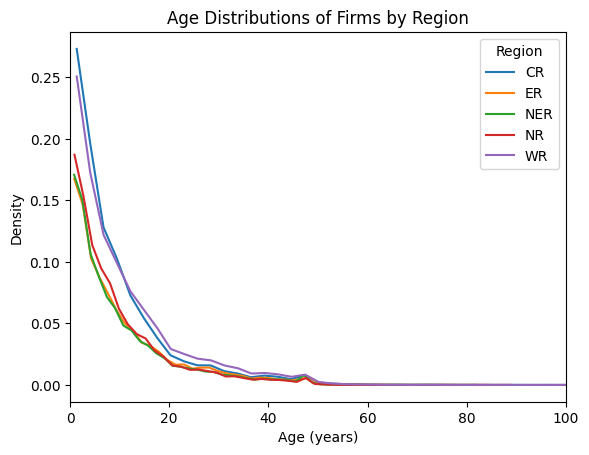

In [113]:
fig, ax = plt.subplots()

for region, group in df_alive.groupby('Region2'):
    counts, bin_edges = np.histogram(group['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Line plot for age density for each region
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
        label=region,
    )

plt.title('Age Distributions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.show()

C:\Users\chong\AppData\Local\Temp\ipykernel_12884\1902783782.py:10: RuntimeWarning: divide by zero encountered in log
  np.log(counts / counts.sum()),  # Normalize to get density


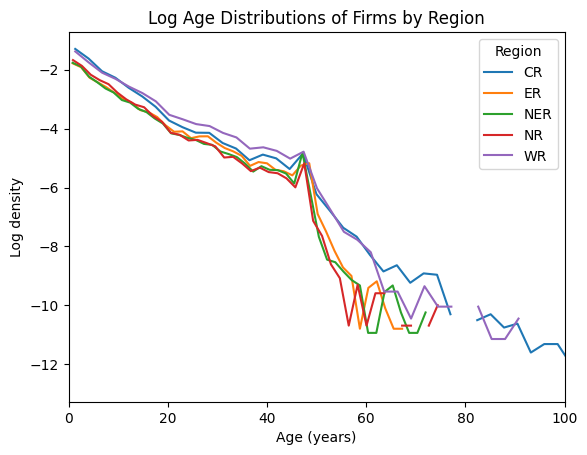

In [114]:
# Plotting log densities for each region

for region, group in df_alive.groupby('Region2'):
    counts, bin_edges = np.histogram(group['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Line plot for age density for each region
    plt.plot(
        bin_midpoints,
        np.log(counts / counts.sum()),  # Normalize to get density
        label=region,
    )

plt.title('Log Age Distributions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Log density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.show()

In [115]:
from scipy.stats import ks_2samp, kruskal

region_names = df_alive['Region2'].dropna().unique()

for i, region1 in enumerate(region_names):
    for region2 in region_names[i+1:]:
        ages1 = df_alive[(df_alive['Region2'] == region1) & (df_alive['Sector'] == 'G')]['Age'].dropna()
        ages2 = df_alive[(df_alive['Region2'] == region2) & (df_alive['Sector'] == 'G')]['Age'].dropna()
        # Take a random sample of 10000 ages

        stat, p_value = ks_2samp(ages1, ages2)
        print(f"KS test between {region1} and {region2}: p-value = {p_value:.4f}")

groups = [
    group['Age'].dropna()
    for _, group in df_alive.groupby('Region2')
]
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis test across all regions: p-value = {p_value:.4f}")
print(p_value)

KS test between CR and WR: p-value = 0.0000
KS test between CR and NR: p-value = 0.0000
KS test between CR and ER: p-value = 0.0000
KS test between CR and NER: p-value = 0.0000
KS test between WR and NR: p-value = 0.0000
KS test between WR and ER: p-value = 0.0695
KS test between WR and NER: p-value = 0.0000
KS test between NR and ER: p-value = 0.0000
KS test between NR and NER: p-value = 0.0000
KS test between ER and NER: p-value = 0.0000
Kruskal-Wallis test across all regions: p-value = 0.0000
6.622435907582441e-227


Creating a new dataframe for the mean age

In [116]:
df_meanage = pd.DataFrame()

# Group by Region, count total firms, and sum 'status' to get number alive
df_meanage = df_analysis.groupby('Region2').agg(
    Mean_Age=('Age', 'mean'),
).reset_index()

In [117]:
df_meanage.head()

,Region2,Mean_Age
0,CR,17.767010
1,ER,16.156001
2,NER,15.833238
3,NR,13.124843
4,WR,14.911135


In [118]:
from scipy.stats import ttest_ind

ages1 = df_alive[df_alive['Region2'] == 'ER']['Age']
ages2 = df_alive[df_alive['Region2'] == 'WR']['Age']

stat, p_value = ttest_ind(ages1, ages2, equal_var=False)
print(p_value)

3.98584703071945e-05


Analysing age distributions within regions

In [119]:
# Creating a dataframe for each region
df_central = df_agedistribution[df_agedistribution['Region2'] == 'CR'].copy()
df_west = df_agedistribution[df_agedistribution['Region2'] == 'WR'].copy()
df_north = df_agedistribution[df_agedistribution['Region2'] == 'NR'].copy()
df_east = df_agedistribution[df_agedistribution['Region2'] == 'ER'].copy()
df_north_east = df_agedistribution[df_agedistribution['Region2'] == 'NER'].copy()

df_list = [df_central, df_west, df_north, df_east, df_north_east]

df_central.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.786448,CR
4,53396472E,H,0,2019-04-11 21:20:43,2020-10-10 09:36:00,3.665982,CR
7,31989700A,G,0,1983-12-03 00:00:00,1988-10-26 19:12:00,39.019849,CR
10,200007504H,F,1,2000-08-29 00:00:00,NaT,22.280630,CR
11,201826023E,M,1,2018-07-31 00:00:00,NaT,4.361396,CR


Inter-sector analysis

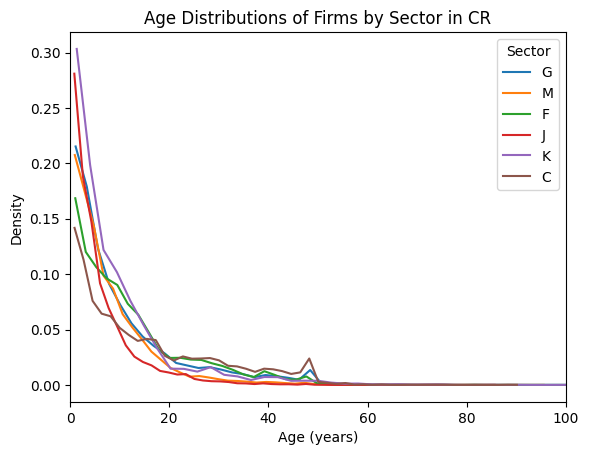

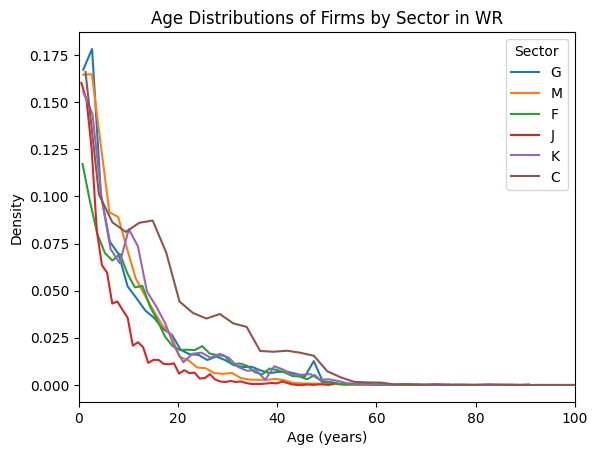

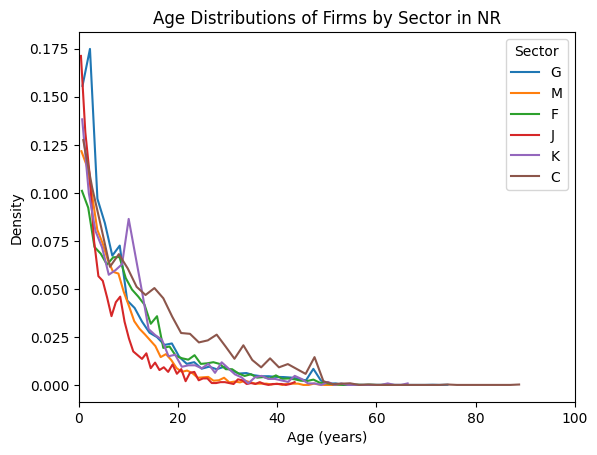

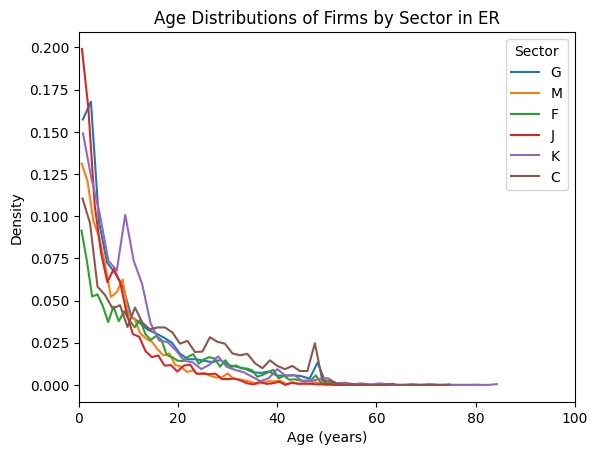

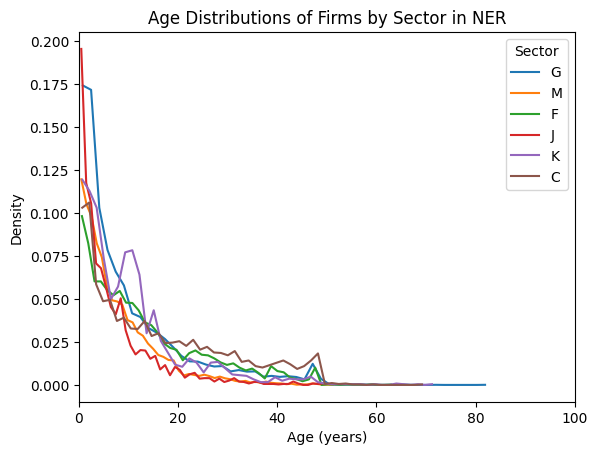

In [120]:
# Creating dataframes for only alive firms in each region
df_central_alive = df_central[df_central['status'] == 1].copy()
df_west_alive = df_west[df_west['status'] == 1].copy()
df_north_alive = df_north[df_north['status'] == 1].copy()
df_east_alive = df_east[df_east['status'] == 1].copy()
df_north_east_alive = df_north_east[df_north_east['status'] == 1].copy()

df_alive_list = [df_central_alive, df_west_alive, df_north_alive, df_east_alive, df_north_east_alive]

# Plotting the age distributions for each region by sector

for df in df_alive_list:
    fig, ax = plt.subplots()
    for sector in sector_list:
        counts, bin_edges = np.histogram(df[df['Sector'] == sector]['Age'].dropna(), bins=50)
        # Calculate bin midpoints
        bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
        # Line plot for age density for each region
        plt.plot(
            bin_midpoints,
            counts / counts.sum(),  # Normalize to get density
            label=sector,
        )
    plt.title(f'Age Distributions of Firms by Sector in {df["Region2"].iloc[0]}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.legend(title='Sector')
    plt.xlim(left=0, right=100)
    plt.show()

# G : Wholesale and Retail Trade
# M : Real Estate Activities
# F : Construction
# J : PUBLISHING, BROADCASTING, AND CONTENT PRODUCTION AND DISTRIBUTION ACTIVITIES
# K : TELECOMMUNICATIONS, COMPUTER PROGRAMMING, CONSULTANCY, COMPUTING INFRASTRUCTURE, AND OTHER INFORMATION SERVICE ACTIVITIES
# C : MANUFACTURING

Temporal analysis

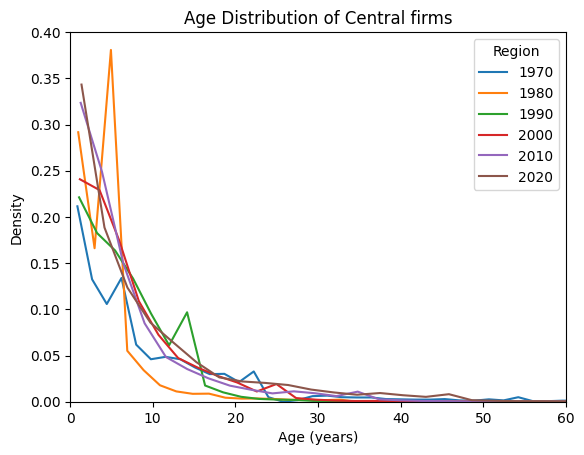

In [121]:
# Create 10 equally spaced years between 1970 and 2020
years = np.linspace(1970, 2020, 6)

# Convert years to datetime (using January 1st for each year)
dates = pd.to_datetime(years.astype(int).astype(str) + '-01-01')

for date in dates:

    # Filter firms alive at the given date
    df_filtered = df_central[
        (df_central['Entry Date'] < date) &
        ((df_central['Exit Date'].isna()) | (df_central['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25
    
    # Line plot for age density
    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
        label=f'{date.year}'
    )
plt.title(f'Age Distribution of Central firms')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Region')
plt.xlim(left=0, right=60)
plt.ylim(top=0.4, bottom=0)
plt.show()


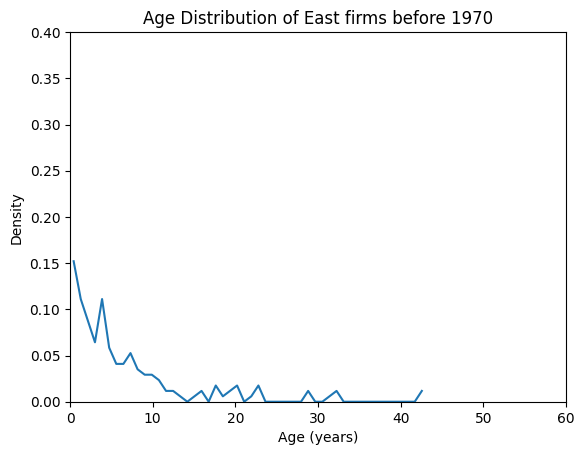

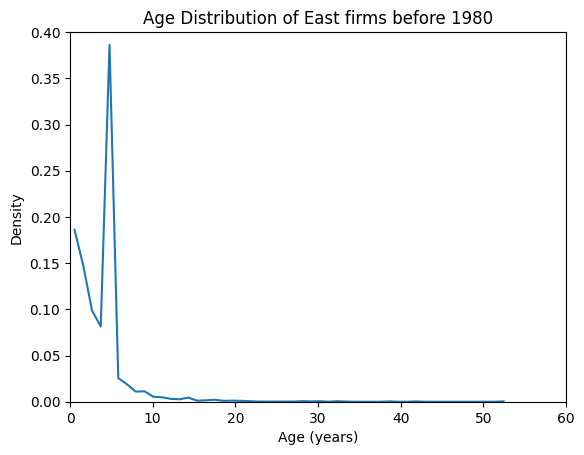

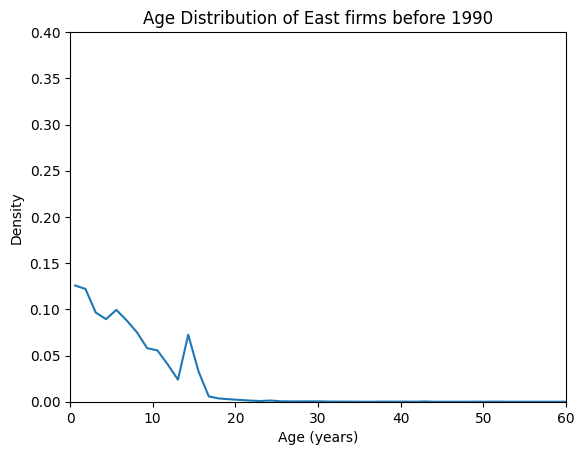

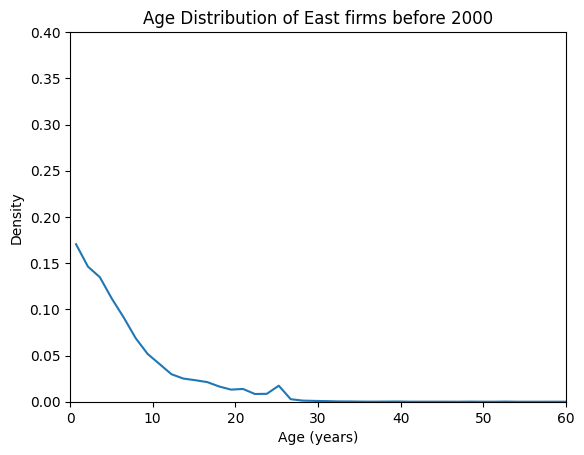

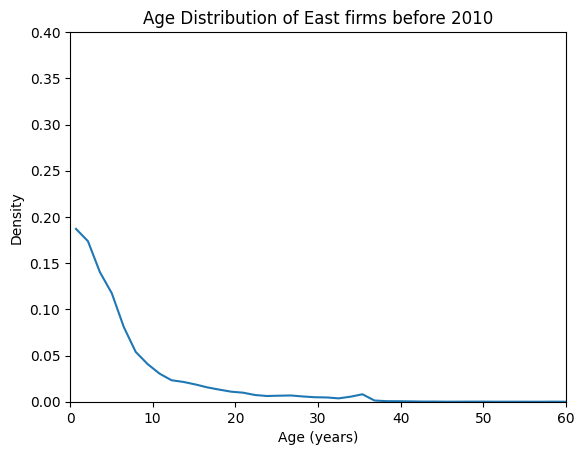

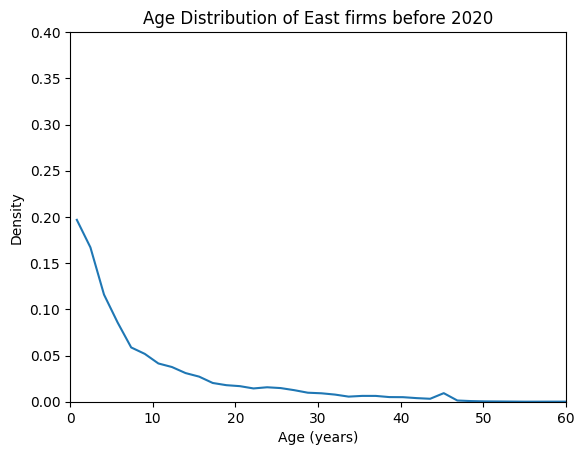

In [122]:
# Create 10 equally spaced years between 1970 and 2020
years = np.linspace(1970, 2020, 6)

# Convert years to datetime (using January 1st for each year)
dates = pd.to_datetime(years.astype(int).astype(str) + '-01-01')

for date in dates:
    fig, ax = plt.subplots()
    # Filter firms alive at the given date
    df_filtered = df_east[
        (df_east['Entry Date'] < date) &
        ((df_east['Exit Date'].isna()) | (df_east['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25
    
    # Line plot for age density
    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
    )
    plt.title(f'Age Distribution of East firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

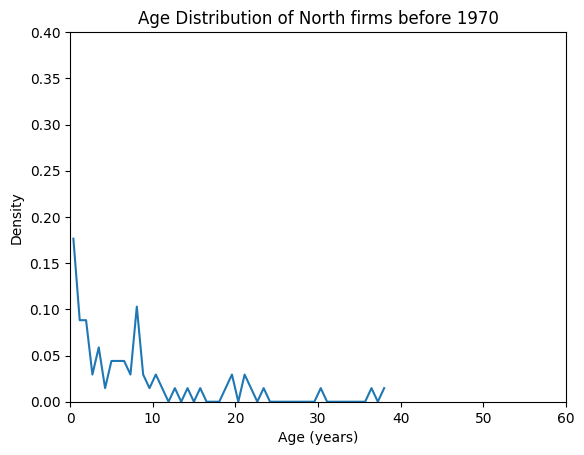

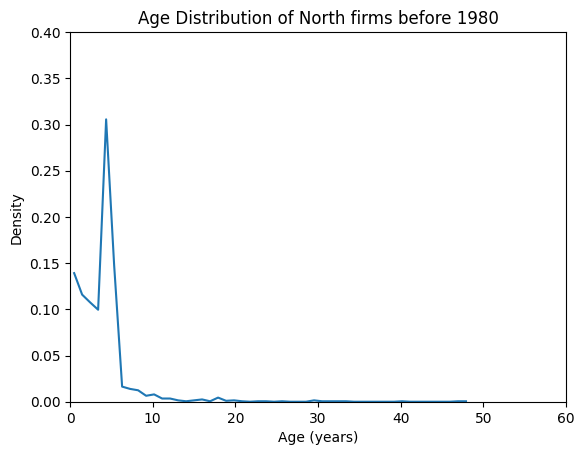

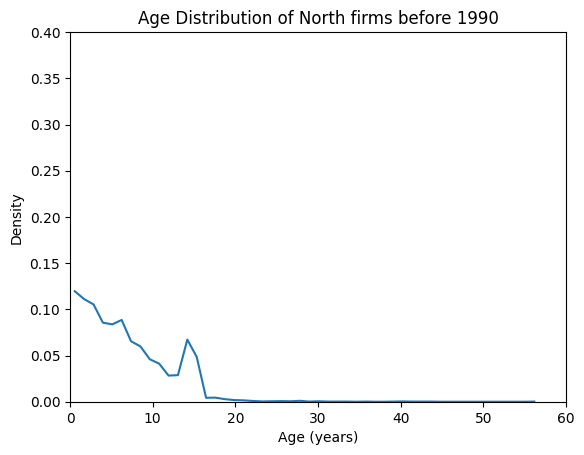

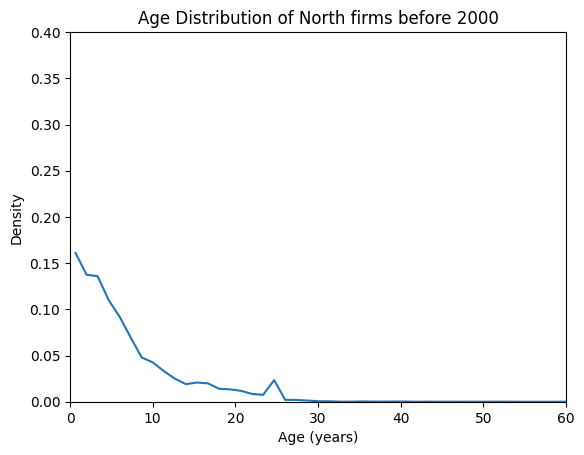

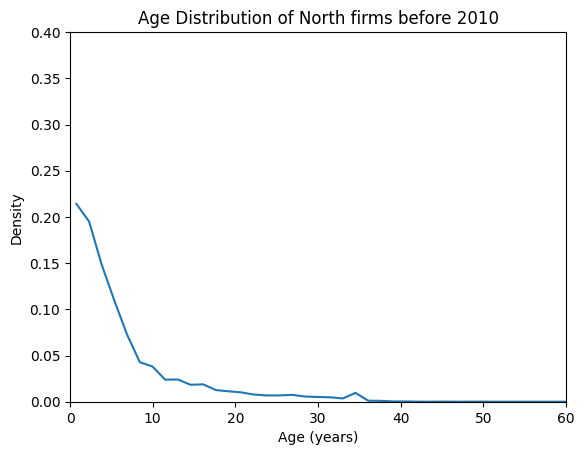

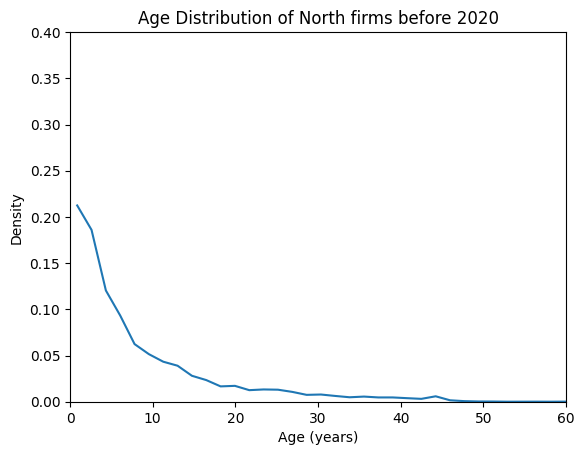

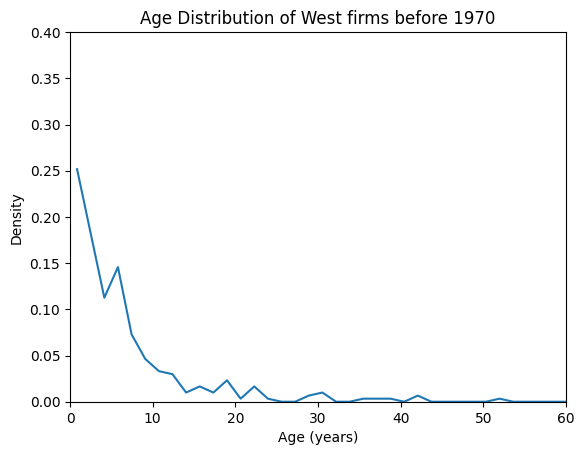

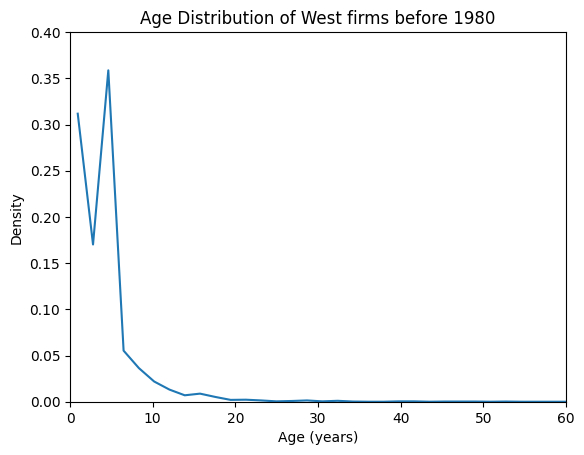

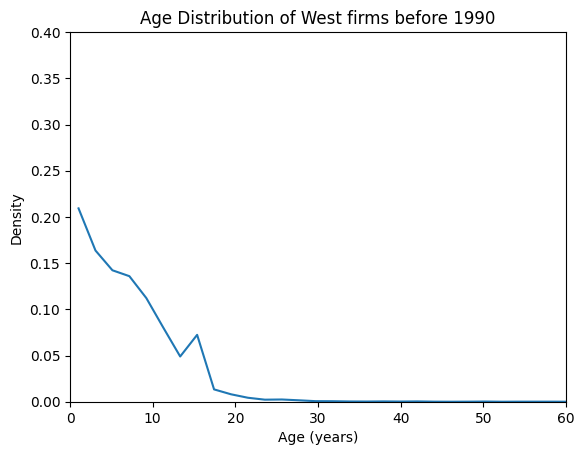

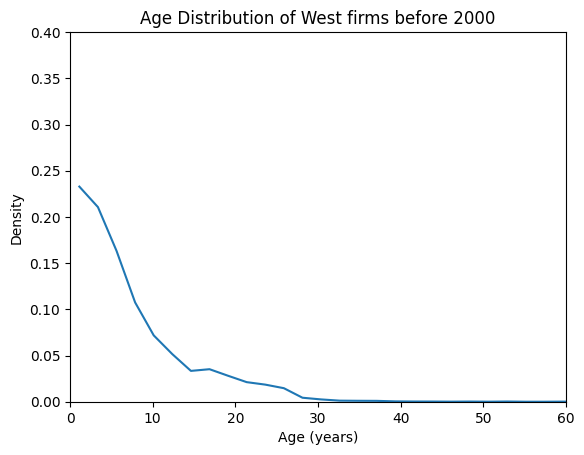

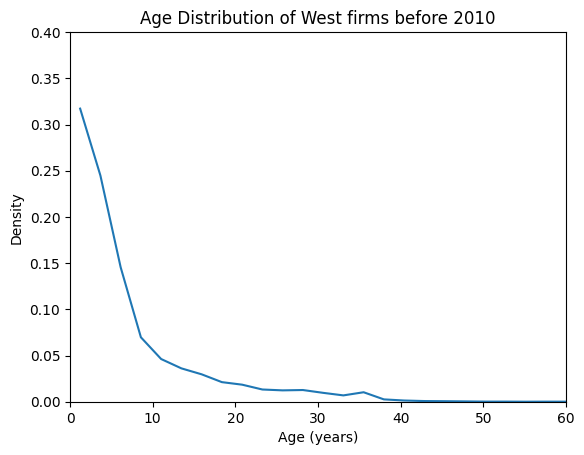

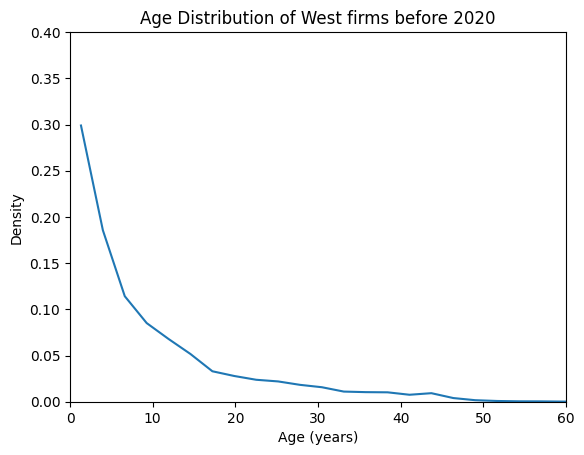

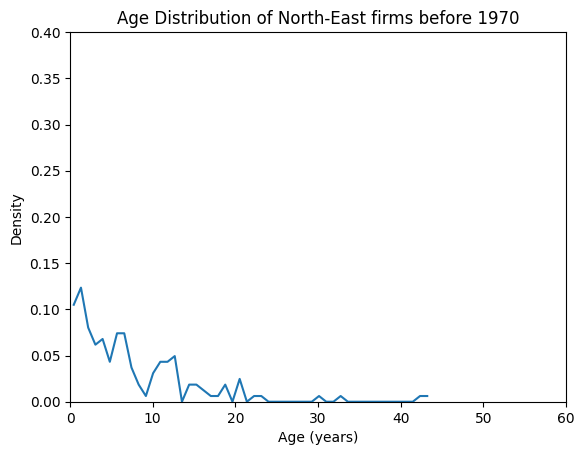

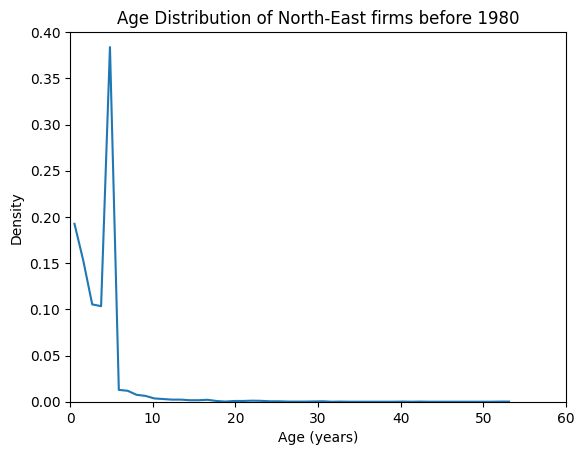

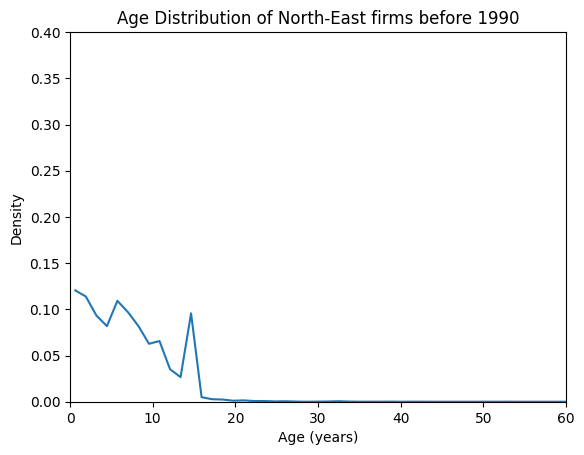

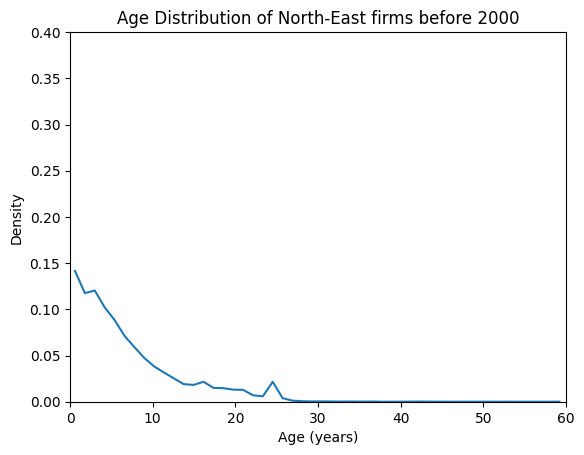

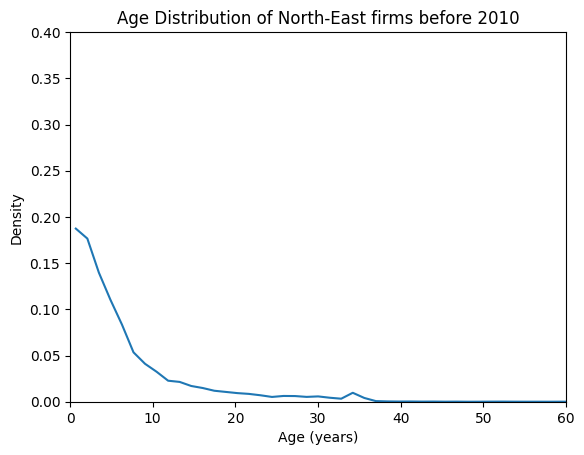

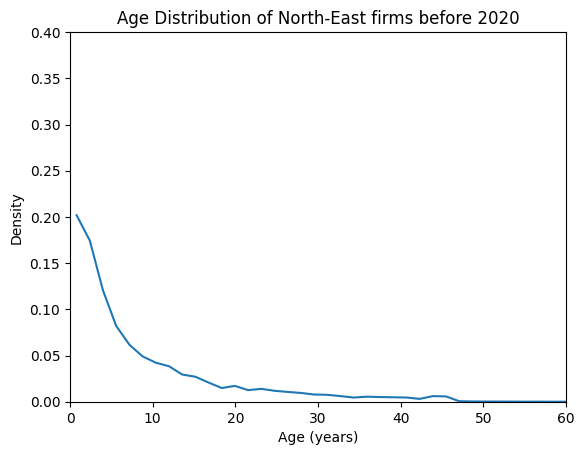

In [123]:
# Plot age distribution over time for North region
years = np.linspace(1970, 2020, 6)
dates = pd.to_datetime(years.astype(int).astype(str) + '-01-01')

for date in dates:
    fig, ax = plt.subplots()
    df_filtered = df_north[
        (df_north['Entry Date'] < date) &
        ((df_north['Exit Date'].isna()) | (df_north['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),
    )
    plt.title(f'Age Distribution of North firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

# Plot age distribution over time for West region
for date in dates:
    fig, ax = plt.subplots()
    df_filtered = df_west[
        (df_west['Entry Date'] < date) &
        ((df_west['Exit Date'].isna()) | (df_west['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),
    )
    plt.title(f'Age Distribution of West firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

# Plot age distribution over time for North-East region
for date in dates:
    fig, ax = plt.subplots()
    df_filtered = df_north_east[
        (df_north_east['Entry Date'] < date) &
        ((df_north_east['Exit Date'].isna()) | (df_north_east['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),
    )
    plt.title(f'Age Distribution of North-East firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

Plotting survival fractions against age

In [124]:
df_central.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.786448,CR
4,53396472E,H,0,2019-04-11 21:20:43,2020-10-10 09:36:00,3.665982,CR
7,31989700A,G,0,1983-12-03 00:00:00,1988-10-26 19:12:00,39.019849,CR
10,200007504H,F,1,2000-08-29 00:00:00,NaT,22.280630,CR
11,201826023E,M,1,2018-07-31 00:00:00,NaT,4.361396,CR


[2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009
 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995
 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981
 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969 1968 1967
 1966 1965 1964 1963 1962]
[34090, 33300, 28526, 25941, 23031, 18538, 15852, 14093, 14022, 12299, 10840, 9757, 8561, 7436, 6558, 6539, 5315, 4693, 4106, 3437, 2816, 2270, 2653, 2292, 1728, 2034, 1958, 1940, 2054, 1746, 1468, 1281, 1280, 1197, 1010, 939, 724, 607, 872, 1042, 832, 910, 762, 637, 616, 468, 463, 1502, 697, 280, 223, 149, 136, 134, 86, 71, 72, 40, 58, 64, 26]
[729, 4281, 7993, 10701, 14688, 15047, 17536, 19654, 24838, 21515, 21314, 21907, 21229, 21948, 21654, 21853, 20573, 19740, 19620, 19216, 19033, 17743, 19649, 18755, 16240, 17582, 18083, 16861, 17053, 16501, 14677, 13946, 12540, 11813, 11335, 10968, 9931, 8534, 10526, 10466, 8618, 8321, 6349, 6472, 5239, 3427, 3088, 10298, 4265, 1144, 803, 6

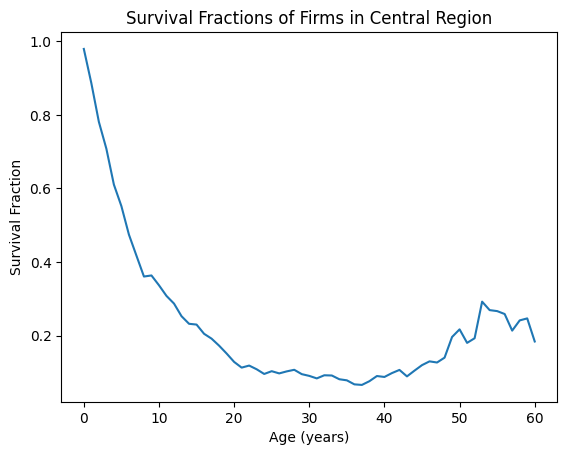

In [125]:
df_alivecr = df_central.copy()
df_alivecr['Age rounded'] = df_alivecr['Age'].round().astype(int)
# Convert Entry Date to only show the year
df_alivecr['Entry Date'] = df_alivecr['Entry Date'].dt.year
df_alivecr.head()

# Create list of 61 years from 1962 to 2022
years = np.arange(1962, 2023, 1)
years = years[::-1]
print(years)

# Create list of ages from 0 to 60
ages = np.arange(0, 61, 1)

# Create list of alive firms for each year
alive_counts = []
for year in years:
    alive_count = df_alivecr[
        (df_alivecr['Entry Date'] == year) &
        (df_alivecr['Exit Date'].isna())
    ].shape[0]
    alive_counts.append(alive_count)

print(alive_counts)

# Create list of dead firms for each year
dead_counts = []
for year in years:
    dead_count = df_alivecr[
        (df_alivecr['Entry Date'] == year) &
        (df_alivecr['status'] == 0)
    ].shape[0]
    dead_counts.append(dead_count)

print(dead_counts)

# Create list of survival fractions
survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))
print(survival_fractions)

plt.plot(ages, survival_fractions)
plt.title('Survival Fractions of Firms in Central Region')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.show()

In [126]:
df_agedistribution.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
0,53376145W,N,0,2018-01-13 10:32:56,2020-04-30 09:36:00,4.906229,NR
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.786448,CR
3,200412424K,G,1,2004-09-28 17:56:29,NaT,18.198494,WR
4,53396472E,H,0,2019-04-11 21:20:43,2020-10-10 09:36:00,3.665982,CR
5,48376900B,S,0,1993-04-12 00:00:00,1999-12-24 04:48:00,29.661875,NER


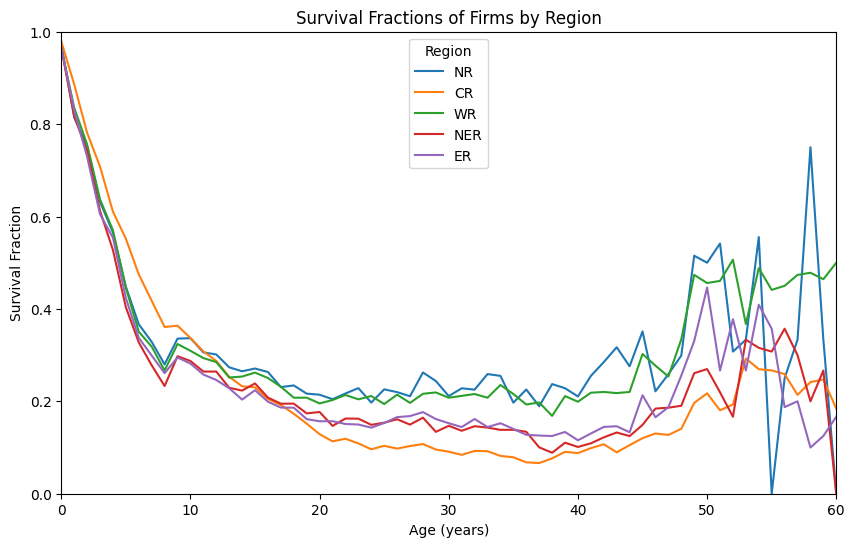

In [ ]:
# Plot survival fractions against age for each region

regions_list = df_agedistribution['Region2'].unique()

# Create list of 61 years from 1962 to 2022
years = np.arange(1962, 2023, 1)
years = years[::-1]

# Create list of ages from 0 to 60
ages = np.arange(0, 61, 1)

plt.figure(figsize=(10, 6))

for region in regions_list:
    df_region = df_agedistribution.copy()
    df_region = df_region[df_region['Region2'] == region]
    # Convert Entry Date to only show the year
    df_region['Entry Date'] = df_region['Entry Date'].dt.year

    # Create list of alive/dead firms for each year
    alive_counts = []
    dead_counts = []
    for year in years:
        alive_count = df_region[
            (df_region['Entry Date'] == year) &
            (df_region['Exit Date'].isna())
        ].shape[0]
        alive_counts.append(alive_count)

        dead_count = df_region[
            (df_region['Entry Date'] == year) &
            (df_region['status'] == 0)
        ].shape[0]
        dead_counts.append(dead_count)

    # Create list of survival fractions
    survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))

    plt.plot(ages, survival_fractions, label=region)

plt.title('Survival Fractions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend(title='Region')
plt.xlim(0, 60)
plt.ylim(0, 1)
plt.show()

Comparing whether survival fractions are significantly different for specific sectors

Alive counts (NR): [4332, 4520, 4174, 3018, 2752, 2544, 2258, 1931, 2090, 1616, 1395, 1224, 1148, 1012, 908, 906, 753, 626, 619, 502, 402, 337, 377, 350, 263, 307, 285, 252, 301, 261, 199]
Dead counts (NR): [123, 1029, 1371, 1758, 2116, 3136, 3898, 3944, 5377, 3198, 2748, 2778, 2660, 2686, 2518, 2437, 2105, 2086, 2022, 1815, 1474, 1310, 1361, 1181, 1070, 1052, 1011, 942, 846, 809, 743]
Alive counts (WR): [5963, 6487, 6119, 4965, 3931, 3698, 3158, 2803, 2875, 2450, 2190, 2074, 1957, 1687, 1551, 1546, 1371, 1173, 1039, 915, 691, 621, 657, 644, 528, 504, 597, 488, 533, 514, 422]
Dead counts (WR): [218, 1277, 1975, 2829, 2964, 4594, 5848, 6003, 7906, 5110, 4890, 4989, 4909, 5021, 4564, 4351, 4103, 3894, 3960, 3486, 2845, 2442, 2417, 2508, 1968, 2092, 2188, 1994, 1931, 1831, 1609]
MLE for mu: 0.09779774927418274


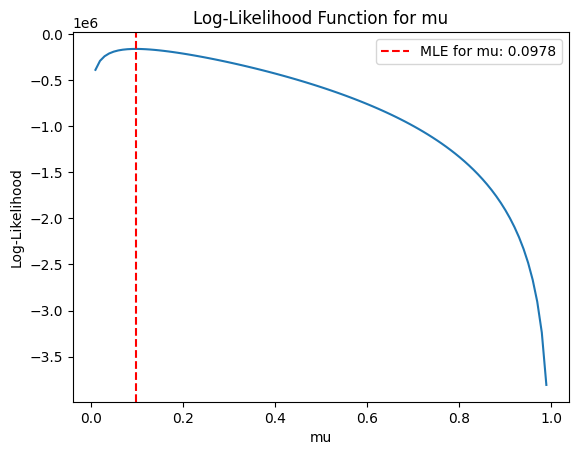

In [ ]:
# H0: Death rate is constant across regions
# H1: Death rate is not constant across regions

# We want to find the MLE for mu
df_nr = df_agedistribution.copy()
df_nr = df_nr[(df_nr['Region2'] == 'NR')]
df_wr = df_agedistribution.copy()
df_wr = df_wr[(df_wr['Region2'] == 'WR')]
# Convert Entry Date to only show the year
df_nr['Entry Date'] = df_nr['Entry Date'].dt.year
df_wr['Entry Date'] = df_wr['Entry Date'].dt.year
# Create list of counts of alive/dead firms for each year for NR
years = np.arange(1992, 2023, 1)
years = years[::-1]
alive_counts_nr = []
dead_counts_nr = []
for year in years:
    alive_count = df_nr[
        (df_nr['Entry Date'] == year) &
        (df_nr['Exit Date'].isna())
    ].shape[0]
    alive_counts_nr.append(alive_count)

    dead_count = df_nr[
        (df_nr['Entry Date'] == year) &
        (df_nr['status'] == 0)
    ].shape[0]
    dead_counts_nr.append(dead_count)

print(f'Alive counts (NR): {alive_counts_nr}')
print(f'Dead counts (NR): {dead_counts_nr}')

# Create list of counts of alive/dead firms for each year for WR
alive_counts_wr = []
dead_counts_wr = []
for year in years:
    alive_count = df_wr[
        (df_wr['Entry Date'] == year) &
        (df_wr['Exit Date'].isna())
    ].shape[0]
    alive_counts_wr.append(alive_count)

    dead_count = df_wr[
        (df_wr['Entry Date'] == year) &
        (df_wr['status'] == 0)
    ].shape[0]
    dead_counts_wr.append(dead_count)

print(f'Alive counts (WR): {alive_counts_wr}')
print(f'Dead counts (WR): {dead_counts_wr}')

# Probability of observing x_i:
# p = pow((1-phi**i), dead_counts[i]) * pow(phi**i, alive_counts[i])

# Define the log-likelihood function
def log_likelihood(mu, alive_counts, dead_counts):
    phi = 1 - mu # Say phi is the survival probability (i.e. phi = 1 - mu)
    log_p = 0
    for i in range(1, 31):
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi)
    return log_p
    
mu_values = np.linspace(0.01, 0.99, 100)

# Find the MLE for mu
result = minimize_scalar(lambda mu: -log_likelihood(mu, alive_counts_nr, dead_counts_nr) - log_likelihood(mu, alive_counts_wr, dead_counts_wr), bounds=(0.01, 0.99), method='bounded')
mu_mle = result.x
print(f'MLE for mu: {mu_mle}')

# Plot the log-likelihood function with the MLE
plt.plot(mu_values, log_likelihood(mu_values, alive_counts_nr, dead_counts_nr) + log_likelihood(mu_values, alive_counts_wr, dead_counts_wr))
plt.axvline(mu_mle, color='red', linestyle='--', label=f'MLE for mu: {mu_mle:.4f}')
plt.title('Log-Likelihood Function for mu')
plt.xlabel('mu')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.show()

In [ ]:
# Now assume mu for both regions are different and find the MLE (2 parameter)
def neg_log_likelihood(params, alive_counts1, dead_counts1, alive_counts2, dead_counts2):
    mu1, mu2 = params
    ll1 = log_likelihood(mu1, alive_counts1, dead_counts1)
    ll2 = log_likelihood(mu2, alive_counts2, dead_counts2)
    return -(ll1 + ll2)  # negative for minimization

result = minimize(
    neg_log_likelihood,
    x0=[0.1, 0.1],  # initial guess for mu1 and mu2
    args=(alive_counts_nr, dead_counts_nr, alive_counts_wr, dead_counts_wr),
    bounds=[(0.01, 0.99), (0.01, 0.99)]
)
mu_nr_mle, mu_wr_mle = result.x
print(mu_nr_mle, mu_wr_mle)

0.09828650123734556 0.09751407814212187


In [ ]:
# Calculate the log-likelihood for H0
ll_h0 = log_likelihood(mu_mle, alive_counts_nr, dead_counts_nr) + log_likelihood(mu_mle, alive_counts_wr, dead_counts_wr)
print(f'Log-likelihood for H0: {ll_h0}')

# Calculate the log-likelihood for H1
ll_h1 = log_likelihood(mu_nr_mle, alive_counts_nr, dead_counts_nr) + log_likelihood(mu_wr_mle, alive_counts_wr, dead_counts_wr)
print(f'Log-likelihood for H1: {ll_h1}')

# Calculate the likelihood ratio test statistic
lrt_statistic = 2 * (ll_h1 - ll_h0)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')

# Calculate the p-value for the likelihood ratio test
from scipy.stats import chi2

# Degrees of freedom: 1 for H0 and 2 for H1, so df = 2 - 1 = 1
df = 1
p_value = chi2.sf(lrt_statistic, df)
print(f'P-value for the likelihood ratio test: {p_value}')

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are not constant across regions.")
else:
    print("Fail to reject H0: Death rates are constant across regions.")

Log-likelihood for H0: -163113.2384385345
Log-likelihood for H1: -163112.10778951843
Likelihood Ratio Test Statistic: 2.261298032128252
P-value for the likelihood ratio test: 0.13264284040602534
Fail to reject H0: Death rates are constant across regions.
2.261298032128252 0.13264284040602534


Defining functions

In [ ]:
def plot_age_distribution(df, *, year='2023', sector=None, label=None):
    """
    Plot the age distribution of firms.
    
    Parameters:
    df: DataFrame containing the firms.
    year: The year to filter the firms by.
    sector: The sector to filter the firms by (optional).
    label: Label for the plot (optional).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Ensure 'Entry Date' and 'Exit Date' are datetime objects
    df['Entry Date'] = pd.to_datetime(df['Entry Date'])
    df['Exit Date'] = pd.to_datetime(df['Exit Date'], errors='coerce')
    # Convert year to datetime object
    date = pd.to_datetime(year + '-01-01') 

    # Filter firms alive at the given date
    df_filtered = df.copy()
    df_filtered = df[
        (df['Entry Date'] < date) &
        ((df['Exit Date'].isna()) | (df['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    # Filter by sector if provided
    if sector is not None:
        df_filtered = df_filtered[df_filtered['Sector'] == sector]
    
    # Line plot for age density
    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
        label=label
    )

def log_likelihood(mu, alive_counts, dead_counts):
    phi = 1 - mu # Say phi is the survival probability (i.e. phi = 1 - mu)
    log_p = 0
    for i in range(1, len(alive_counts)):
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi)
    return log_p

def neg_log_likelihood(params, alive_counts1, dead_counts1, alive_counts2, dead_counts2):
    mu1, mu2 = params
    ll1 = log_likelihood(mu1, alive_counts1, dead_counts1)
    ll2 = log_likelihood(mu2, alive_counts2, dead_counts2)
    return -(ll1 + ll2)  # negative for minimization

# Function to perform the likelihood ratio test
def likelihood_ratio_test(df_a, df_b):
    """
    Perform the likelihood ratio test to compare the death rates across two dataframes.
    where H0: Death rate is constant across df_a and df_b
    and H1: Death rate is not constant across df_a and df_b
    
    Parameters:
    df_a: DataFrame containing the first set of firms.
    df_b: DataFrame containing the second set of firms.
    
    Returns:
    lrt_statistic: Likelihood ratio test statistic
    p_value: p-value for the test
    """
    
    df1 = df_a.copy()
    df2 = df_b.copy()

    # Create list of 31 years from 1992 to 2022
    years = np.arange(1992, 2023, 1)
    years = years[::-1]

    # Convert Entry Date to only show the year
    df1['Entry Date'] = df1['Entry Date'].dt.year
    df2['Entry Date'] = df2['Entry Date'].dt.year

    # Create list of counts of alive/dead firms for each year for NR
    alive_counts_1 = []
    dead_counts_1 = []
    alive_counts_2 = []
    dead_counts_2 = []
    for year in years:
        alive_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['Exit Date'].isna())
        ].shape[0]
        alive_counts_1.append(alive_count1)

        dead_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['status'] == 0)
        ].shape[0]
        dead_counts_1.append(dead_count1)

        alive_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['Exit Date'].isna())
        ].shape[0]
        alive_counts_2.append(alive_count2)

        dead_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['status'] == 0)
        ].shape[0]
        dead_counts_2.append(dead_count2)

    # Calculate the MLE for H0
    mu_mle = minimize_scalar(
        lambda mu: -log_likelihood(mu, alive_counts_1, dead_counts_1) - log_likelihood(mu, alive_counts_2, dead_counts_2),
        bounds=(0.01, 0.99),
        method='bounded'
    ).x

    # Calculate the log-likelihood for H0
    ll_h0 = log_likelihood(mu_mle, alive_counts_1, dead_counts_1) + log_likelihood(mu_mle, alive_counts_2, dead_counts_2)

    # Calculate the MLE for H1
    result = minimize(
        neg_log_likelihood,
        x0=[0.1, 0.1],  # initial guess for mu1 and mu2
        args=(alive_counts_1, dead_counts_1, alive_counts_2, dead_counts_2),
        bounds=[(0.01, 0.99), (0.01, 0.99)]
    )
    mu_1_mle, mu_2_mle = result.x

    # Calculate the log-likelihood for H1
    ll_h1 = log_likelihood(mu_1_mle, alive_counts_1, dead_counts_1) + log_likelihood(mu_2_mle, alive_counts_2, dead_counts_2)

    # Calculate the likelihood ratio test statistic
    lrt_statistic = 2 * (ll_h1 - ll_h0)

    # Calculate the p-value for the likelihood ratio test
    p_value = chi2.sf(lrt_statistic, df=1)

    return lrt_statistic, p_value, mu_mle, mu_1_mle, mu_2_mle

# Create filtered dataframes
def filter_dataframe(category, filter, *, category2 = None, filter2 = None):
    """
    Filter the df_agedistribution dataframe based on the given category and filter.
    If category2 and filter2 are provided, it will filter based on both conditions.
    """
    if category2 is not None and filter2 is not None:
        df = df_agedistribution.copy()
        df = df[(df[category] == filter) & (df[category2] == filter2)]
    else:
        df = df_agedistribution.copy()
        df = df[df[category] == filter]
        
    return df

def plot_survival_fractions(df, label):
    """
    Plot survival fractions against age.
    """

    # Create list of ages from 0 to 30
    ages_sf = np.arange(0, 31, 1)
    # Create list of 31 years from 1992 to 2022
    years = np.arange(1992, 2023, 1)
    years = years[::-1]

    # Convert Entry Date to only show the year
    df['Entry Date'] = df['Entry Date'].dt.year

    # Create list of alive/dead firms for each year
    alive_counts = []
    dead_counts = []
    for year in years:
        alive_count = df[
            (df['Entry Date'] == year) &
            (df['Exit Date'].isna())
        ].shape[0]
        alive_counts.append(alive_count)

        dead_count = df[
            (df['Entry Date'] == year) &
            (df['status'] == 0)
        ].shape[0]
        dead_counts.append(dead_count)

    # Create list of survival fractions
    survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))

    plt.plot(ages_sf, survival_fractions, label=label, marker='o', markersize=3)

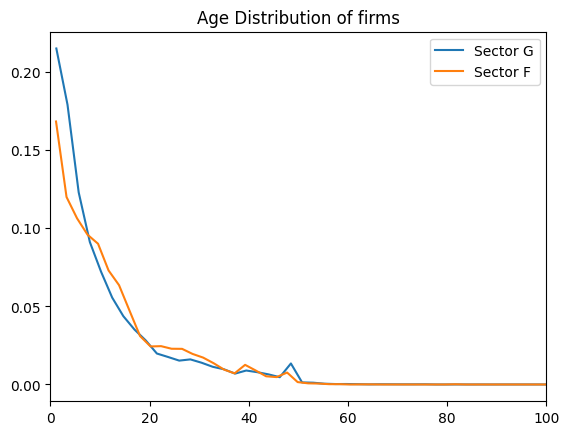

In [ ]:
plot_age_distribution(df_central, year='2023', sector='G', label='Sector G')
plot_age_distribution(df_central, year='2023', sector='F', label='Sector F')

plt.title('Age Distribution of firms')
plt.xlim(0,100)
plt.legend()
plt.show()


Sample size for df_a: 191979
Sample size for df_b: 111817
Likelihood Ratio Test Statistic: 2.261298032128252
P-value for the likelihood ratio test: 0.13264284040602534
MLE for mu: 0.09779774927418274
MLE for mu_a: 0.09751407814212187 and MLE for mu_b: 0.09828650123734556
Fail to reject H0: Death rates are not significantly different.


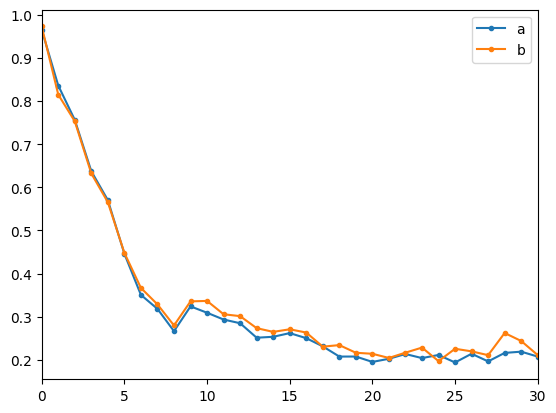

In [163]:
df_a = filter_dataframe('Region2', 'WR')
df_b = filter_dataframe('Region2', 'NR')

print(f'Sample size for df_a: {len(df_a)}')
print(f'Sample size for df_b: {len(df_b)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a, df_b)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}')
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}')

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'a')
plot_survival_fractions(df_b, label = 'b')
plt.xlim(0, 30)
plt.legend()
plt.show()

Sample size for df_a: 10000
Sample size for df_b: 10000
Likelihood Ratio Test Statistic: 0.0
P-value for the likelihood ratio test: 1.0
Fail to reject H0: Death rates are not significantly different.


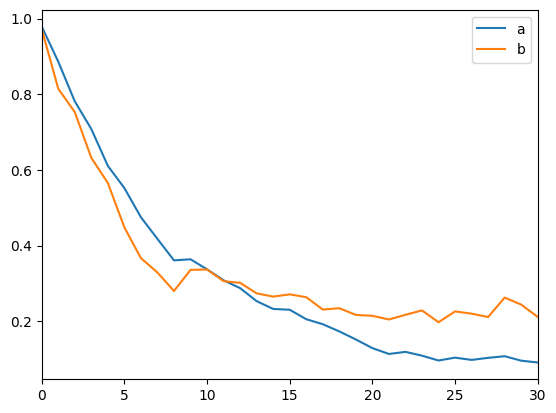

In [134]:
df_a = filter_dataframe('Region2', 'CR')
df_b = filter_dataframe('Region2', 'NR')

# Sample 10,000 firms from each DataFrame (with replacement if not enough rows)
df_a_sample = df_a.sample(n=10000, replace=(len(df_a) < 10000))
df_b_sample = df_b.sample(n=10000, replace=(len(df_b) < 10000))

print(f'Sample size for df_a: {len(df_a_sample)}')
print(f'Sample size for df_b: {len(df_b_sample)}')

# Perform the likelihood ratio test
lrt_statistic, p_value = likelihood_ratio_test(df_a_sample, df_b_sample)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'a')
plot_survival_fractions(df_b, label = 'b')
plt.xlim(0, 30)
plt.legend()
plt.show()

In [ ]:
print(sector_list)
# G : Wholesale and Retail Trade
# M : Real Estate Activities
# F : Construction
# J : PUBLISHING, BROADCASTING, AND CONTENT PRODUCTION AND DISTRIBUTION ACTIVITIES
# K : TELECOMMUNICATIONS, COMPUTER PROGRAMMING, CONSULTANCY, COMPUTING INFRASTRUCTURE, AND OTHER INFORMATION SERVICE ACTIVITIES
# C : MANUFACTURING

['G', 'M', 'F', 'J', 'K', 'C']


plot exponential under mu_mle and mark the points as well

number of firms locally may be better than considering number of firms in the whole country: use likelihood test?

$\mu = \lambda e^{-\beta t}$

In [ ]:
def log_likelihood_exp(params, alive_counts, dead_counts):
    log_p = 0
    a, b = params
    for i in range(1, len(alive_counts)):
        phi = 1 - a*np.exp(-b*i) # Say phi is the survival probability (i.e. phi = 1 - mu)
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi) + math.log(math.comb(alive_counts[i] + dead_counts[i], dead_counts[i]))
    return log_p

# Function to perform the likelihood ratio test
def likelihood_ratio_test_exp(df_a, df_b, *, initial=[0.1,0.01,0.1,0.01]):
    """
    Perform the likelihood ratio test to compare the death rates across two dataframes.
    where H0: Death rate is constant across df_a and df_b
    and H1: Death rate is not constant across df_a and df_b
    
    Parameters:
    df_a: DataFrame containing the first set of firms.
    df_b: DataFrame containing the second set of firms.
    
    Returns:
    lrt_statistic: Likelihood ratio test statistic
    p_value: p-value for the test
    """
    
    df1 = df_a.copy()
    df2 = df_b.copy()

    # Create list of 31 years from 1993 to 2023
    years = np.arange(1993, 2024, 1)
    years = years[::-1]

    # Convert Entry Date to the nearest year
    df1['Entry Date'] = df1['Entry Date'].dt.year + (df1['Entry Date'].dt.month >= 7).astype(int)
    df2['Entry Date'] = df2['Entry Date'].dt.year + (df2['Entry Date'].dt.month >= 7).astype(int)

    # Create list of counts of alive/dead firms for each year for NR
    alive_counts_1 = []
    dead_counts_1 = []
    alive_counts_2 = []
    dead_counts_2 = []
    for year in years:
        alive_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['Exit Date'].isna())
        ].shape[0]
        alive_counts_1.append(alive_count1)

        dead_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['status'] == 0)
        ].shape[0]
        dead_counts_1.append(dead_count1)

        alive_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['Exit Date'].isna())
        ].shape[0]
        alive_counts_2.append(alive_count2)

        dead_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['status'] == 0)
        ].shape[0]
        dead_counts_2.append(dead_count2)

    # H0: a, b are the same for both groups
    def neg_ll_h0(params):
        return -(log_likelihood_exp(params, alive_counts_1, dead_counts_1) +
                 log_likelihood_exp(params, alive_counts_2, dead_counts_2))
    result_h0 = minimize(neg_ll_h0, x0=[0.1,0.05], bounds=[(1e-4, 1), (1e-4, 10)])
    a_mle, b_mle = result_h0.x
    ll_h0 = -result_h0.fun

   # H1: a, b are different for each group
    def neg_log_likelihood(params):
        a1, b1, a2, b2 = params
        ll1 = log_likelihood_exp([a1, b1], alive_counts_1, dead_counts_1)
        ll2 = log_likelihood_exp([a2, b2], alive_counts_2, dead_counts_2)
        return -(ll1 + ll2)  # negative for minimization
    result_h1 = minimize(
        neg_log_likelihood,
        x0=initial,
        bounds=[(1e-4, 1), (1e-4, 10), (1e-4, 1), (1e-4, 10)]
    )
    a1_mle, b1_mle, a2_mle, b2_mle = result_h1.x
    ll_h1 = -result_h1.fun

    # Calculate the likelihood ratio test statistic
    lrt_statistic = 2 * (ll_h1 - ll_h0)

    # Calculate the p-value for the likelihood ratio test
    p_value = chi2.sf(lrt_statistic, df=2)

    return lrt_statistic, p_value, [a_mle, b_mle, a1_mle, b1_mle, a2_mle, b2_mle]

In [ ]:
df_a = filter_dataframe('Region', 'WR', category2='Sector', filter2='G')
df_b = filter_dataframe('Region', 'NR', category2='Sector', filter2='G')

# Perform likelihood ratio test
lrt_statistic, p_value, params = likelihood_ratio_test_exp(df_a, df_b, initial=[0.13,0.02,0.13,0.02])
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'Under H0, MLE for a, b: {params[0]}, {params[1]}')  # Under H0
print(f'Under H1, MLE for a1, b1, a2, b2: {params[2]}, {params[3]}, {params[4]}, {params[5]}')  # Under H1

# Plot survival fractions against age
plot_survival_fractions(df_a, label='WR')
plot_survival_fractions(df_b, label='NR')
ages = np.arange(0, 31, 1)
plt.plot(ages, np.exp(-(params[0] / params[1]) * (np.exp(params[1] * ages) - 1)), linestyle='--', label='H0 Fit')
plt.plot(ages, np.exp(-(params[2] / params[3]) * (np.exp(params[3] * ages) - 1)), linestyle='--', label='H1 Fit 1')
plt.plot(ages, np.exp(-(0.13 / 0.000000001) * (np.exp(0.000000001 * ages) - 1)), linestyle='--', label='H1 Fit 2')
plt.xlim(0, 30)
plt.legend()
plt.show()

a1_exp = params[2]
b1_exp = params[3]

In [ ]:
df_a = filter_dataframe('Region', 'WR', category2='Sector', filter2='G')
plot_log_survival_fractions(df_a, label='WR')
plt.plot(ages, -(a1_power/(1+b1_power*ages))*ages, linestyle='--', label='Power Law Fit')
plt.plot(ages, -(a1_exp/(1+b1_exp*ages))*ages, linestyle=':', label='Exponential Fit')
plt.legend()
plt.show()